In [ ]:
''' Retail Sales Analytics with PySpark and SQL

In this project, I built a complete ETL pipeline using **Google Colab**, **PySpark**, and **Spark SQL** on a real-world retail dataset (Online Retail II). The goal was to clean the data, calculate revenue,Top PRODUCTS, Customer LTV, and prepare it for further analysis or reporting.

**Tools Used**: PySpark, Spark SQL, Google Colab, Excel to CSV conversion, Data Transformation

**Key Skills**: SQL on Spark, Data Cleaning, Revenue Calculation, Aggregation, Schema Handling '''


In [ ]:
'PYSPARK SETUP'

In [12]:

!apt-get install openjdk-11-jdk-headless -qq > /dev/null


!wget -q -O spark.tgz \
  https://archive.apache.org/dist/spark/spark-3.4.1/spark-3.4.1-bin-hadoop3-scala2.13.tgz


!tar -xzf spark.tgz


!pip install -q findspark


In [13]:
import os

os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.4.1-bin-hadoop3-scala2.13"


In [14]:
import findspark
findspark.init()

from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("ColabSpark").getOrCreate()
spark


In [2]:
from google.colab import files
db=files.upload()

Saving Copy of online_retail_II.xlsx to Copy of online_retail_II.xlsx


**`EXTRACTION`**

In [38]:
# Reading the Data of the Excel file using pandas
import pandas as pd
df_excel = pd.read_excel("/content/Copy of online_retail_II.xlsx", sheet_name="Year 2009-2010")
#Converting The Excel file Into CSV format
df_excel.to_csv("/content/retail.csv", index=False)


In [39]:
# Read the CSV file into a Spark DataFrame
# "header=True" tells Spark the first row has column names
# "inferSchema=True" lets Spark automatically detect data types
df = spark.read.csv("/content/retail.csv", header=True, inferSchema=True)
# Register the DataFrame as a temporary SQL view
# This allows you to run SQL queries on the DataFrame using Spark SQL
df.createOrReplaceTempView("sales")

**`TRANSFORMATION`**

In [60]:
# SQL Query to Calculate Revenue per day
daily_revenue_df = spark.sql("""
SELECT TO_DATE(InvoiceDate) AS Day,
       ROUND(SUM(Quantity * Price), 2) AS DailyRevenue
FROM sales
WHERE Invoice IS NOT NULL AND `Customer ID` IS NOT NULL
GROUP BY Day
ORDER BY Day
""").show(n=50,truncate=False)



+----------+------------+
|Day       |DailyRevenue|
+----------+------------+
|2009-12-01|42708.22    |
|2009-12-02|52578.19    |
|2009-12-03|61534.22    |
|2009-12-04|33686.86    |
|2009-12-05|9803.05     |
|2009-12-06|24284.28    |
|2009-12-07|32423.3     |
|2009-12-08|39030.25    |
|2009-12-09|30894.06    |
|2009-12-10|37706.73    |
|2009-12-11|38181.2     |
|2009-12-13|21464.36    |
|2009-12-14|50985.72    |
|2009-12-15|46363.74    |
|2009-12-16|37062.95    |
|2009-12-17|28429.31    |
|2009-12-18|31476.46    |
|2009-12-20|11307.88    |
|2009-12-21|13797.27    |
|2009-12-22|10175.0     |
|2009-12-23|9379.0      |
|2010-01-04|13179.97    |
|2010-01-05|19053.64    |
|2010-01-06|8740.69     |
|2010-01-07|72260.31    |
|2010-01-08|29515.38    |
|2010-01-10|23079.4     |
|2010-01-11|19292.99    |
|2010-01-12|38737.43    |
|2010-01-13|9320.85     |
|2010-01-14|23299.19    |
|2010-01-15|13290.19    |
|2010-01-17|17535.99    |
|2010-01-18|12045.79    |
|2010-01-19|21646.78    |
|2010-01-20|

In [48]:
#SQL Query for TOP Products Bases on their Revenue
spark.sql('''
select
StockCode,
Description,
ROUND(SUM(Quantity * Price),2) AS TOTALRevenue
from sales
where Invoice IS NOT NULL AND  `Customer ID` IS NOT NULL
GROUP BY StockCode, Description
ORDER BY TOTALRevenue DESC''').show(n=50,truncate=False)

+---------+-----------------------------------+------------+
|StockCode|Description                        |TOTALRevenue|
+---------+-----------------------------------+------------+
|85123A   |WHITE HANGING HEART T-LIGHT HOLDER |148876.66   |
|22423    |REGENCY CAKESTAND 3 TIER           |136866.3    |
|84879    |ASSORTED COLOUR BIRD ORNAMENT      |69854.96    |
|85099B   |JUMBO BAG RED RETROSPOT            |51608.4     |
|POST     |POSTAGE                            |45520.86    |
|84347    |ROTATING SILVER ANGELS T-LIGHT HLDR|39902.1     |
|22086    |PAPER CHAIN KIT 50'S CHRISTMAS     |36866.45    |
|47566    |PARTY BUNTING                      |34998.7     |
|85099F   |JUMBO BAG STRAWBERRY               |33893.7     |
|21621    |VINTAGE UNION JACK BUNTING         |33546.96    |
|15056N   |EDWARDIAN PARASOL NATURAL          |33541.65    |
|15056BL  |EDWARDIAN PARASOL BLACK            |31038.7     |
|22189    |CREAM HEART CARD HOLDER            |29774.59    |
|85099C   |JUMBO  BAG BA

In [52]:
#SQL Query for customerlifetimevalue("CustomerLTV")
spark.sql('''
SELECT
`Customer ID`,
ROUND(SUM(Quantity * Price), 2) AS CustomerLTV
FROM sales
WHERE Invoice IS NOT NULL AND `Customer ID` IS NOT NULL
GROUP BY `Customer ID`
ORDER BY CustomerLTV DESC
''').show(n=50,truncate=False)

+-----------+-----------+
|Customer ID|CustomerLTV|
+-----------+-----------+
|18102.0    |341776.73  |
|14646.0    |243853.05  |
|14156.0    |183180.55  |
|14911.0    |137675.91  |
|13694.0    |128172.42  |
|17511.0    |83760.6    |
|15061.0    |82162.74   |
|16684.0    |75610.17   |
|13089.0    |55828.31   |
|16754.0    |54558.18   |
|15311.0    |54093.73   |
|17850.0    |50414.5    |
|13093.0    |46332.26   |
|17949.0    |46144.75   |
|17450.0    |46097.22   |
|16029.0    |40808.3    |
|15838.0    |40053.35   |
|14298.0    |39626.87   |
|12931.0    |37836.86   |
|13798.0    |37222.05   |
|15769.0    |32445.66   |
|13902.0    |30411.26   |
|13081.0    |30363.67   |
|13777.0    |30268.22   |
|17841.0    |29175.41   |
|16705.0    |28707.01   |
|14680.0    |27869.0    |
|13881.0    |27402.98   |
|16422.0    |27304.85   |
|17940.0    |24976.44   |
|14031.0    |23391.33   |
|13408.0    |23365.44   |
|17389.0    |23286.95   |
|16779.0    |22527.56   |
|18251.0    |21964.14   |
|12482.0    

**`LOAD INTO SQLITE DB`**

In [93]:
import sqlite3
import pandas as pd
from pyspark.sql.functions import col

# ✅ Make sure you're starting from Spark DataFrame, not pandas DataFrame
# Example: spark_df = spark.read.csv(...)

# Step 1: Cast InvoiceDate to string in Spark
spark_df_casted = spark_df.withColumn("InvoiceDate", col("InvoiceDate").cast("string"))

# Step 2: Convert to pandas DataFrame
pdf = spark_df_casted.toPandas()

# Step 3: Fix datetime format in pandas
pdf['InvoiceDate'] = pd.to_datetime(pdf['InvoiceDate'], errors='coerce')

# Step 4: Store into SQLite
conn = sqlite3.connect("/content/retail_etl.db")
pdf.to_sql("retail_sales", conn, if_exists="replace", index=False)

# Step 5: Close connection
conn.close()


`**OPTIONAL** `

`**VISULIZATION OF THE TRANSFORMATION QUERIES **`

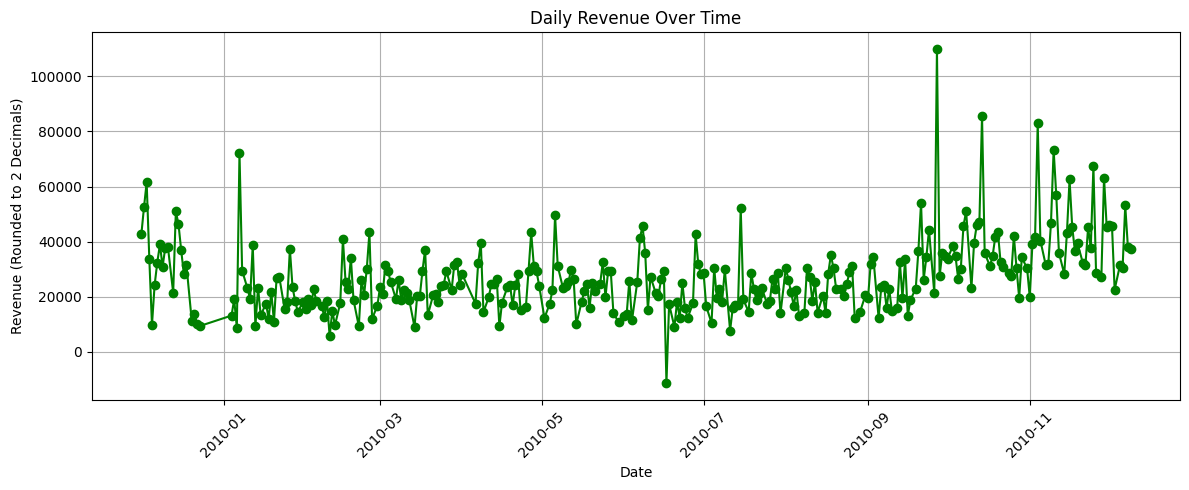

In [64]:
#vizulization of daily revenue
daily_revenue_df = spark.sql("""
SELECT TO_DATE(InvoiceDate) AS Day,
       ROUND(SUM(Quantity * Price), 2) AS DailyRevenue
FROM sales
WHERE Invoice IS NOT NULL AND `Customer ID` IS NOT NULL
GROUP BY Day
ORDER BY Day
""").toPandas()

import matplotlib.pyplot as plt


plt.figure(figsize=(12, 5))
plt.plot(daily_revenue_pd['Day'], daily_revenue_pd['DailyRevenue'], marker='o', color='green')

plt.title("Daily Revenue Over Time")
plt.xlabel("Date")
plt.ylabel("Revenue (Rounded to 2 Decimals)")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

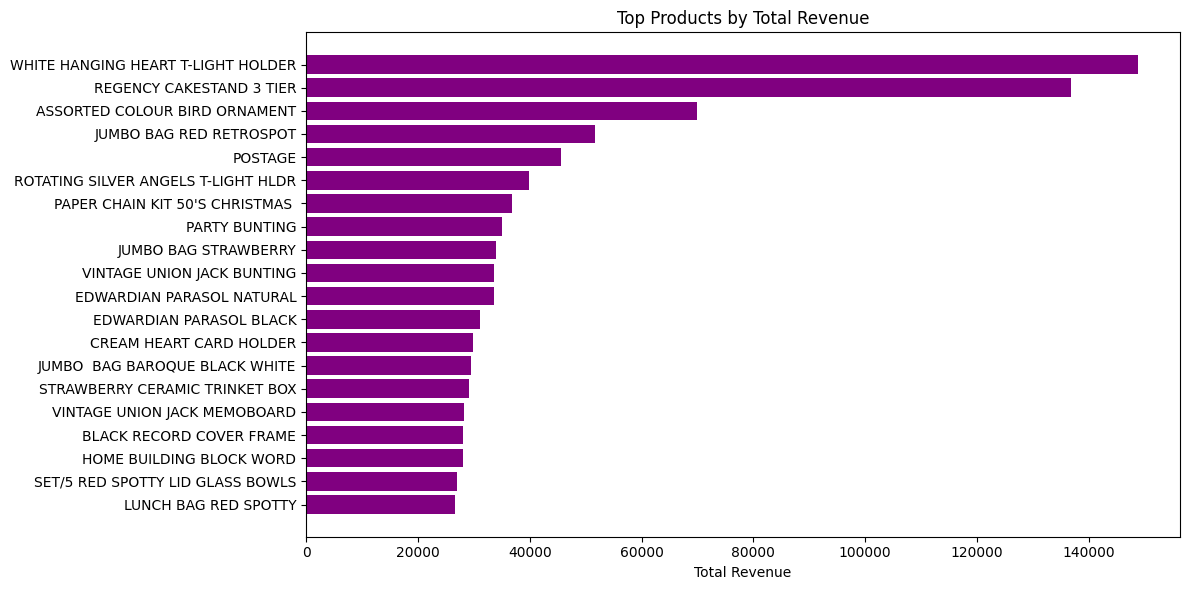

In [65]:
# Visulization of top products by total revenue
top_products_pd = spark.sql('''
select
StockCode,
Description,
ROUND(SUM(Quantity * Price),2) AS TOTALRevenue
from sales
where Invoice IS NOT NULL AND  `Customer ID` IS NOT NULL
GROUP BY StockCode, Description
ORDER BY TOTALRevenue DESC
limit 20''').toPandas()

import matplotlib.pyplot as plt


plt.figure(figsize=(12, 6))
plt.barh(top_products_pd['Description'], top_products_pd['TOTALRevenue'], color='purple')
plt.xlabel('Total Revenue')
plt.title('Top Products by Total Revenue')
plt.gca().invert_yaxis()  # Show highest revenue at the top
plt.tight_layout()
plt.show()

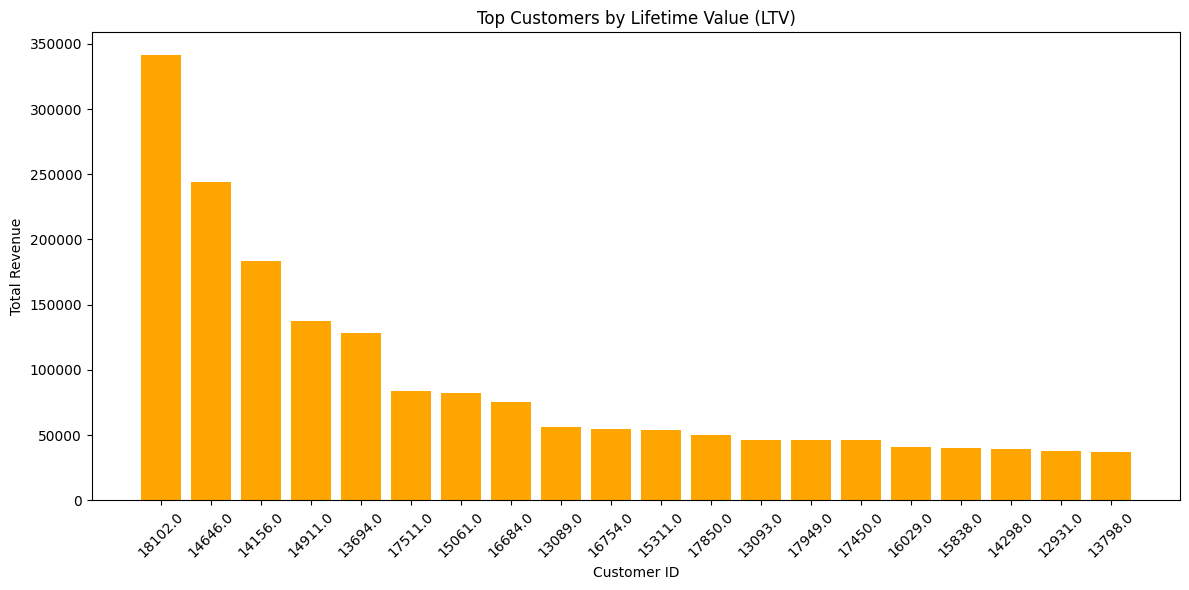

In [68]:
# Visulization of customerlifetimevalue("CustomerLTV")
customer_ltv_df=spark.sql('''
SELECT
`Customer ID`,
ROUND(SUM(Quantity * Price), 2) AS CustomerLTV
FROM sales
WHERE Invoice IS NOT NULL AND `Customer ID` IS NOT NULL
GROUP BY `Customer ID`
ORDER BY CustomerLTV DESC
limit 20
''').toPandas()

import matplotlib.pyplot as plt


customer_ltv_df['Customer ID'] = customer_ltv_df['Customer ID'].astype(str)


plt.figure(figsize=(12, 6))
plt.bar(customer_ltv_df['Customer ID'], customer_ltv_df['CustomerLTV'], color='orange')

plt.title('Top Customers by Lifetime Value (LTV)')
plt.xlabel('Customer ID')
plt.ylabel('Total Revenue')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()